In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# !pip install xgboost
import xgboost
from xgboost import XGBClassifier
# !pip install lightgbm
import lightgbm as lgb
# !pip install catboost
from catboost import CatBoostClassifier, Pool

In [2]:
# データ準備
df = sns.load_dataset('titanic')
df.dropna(inplace=True)
# X, yを作成
X = df.drop(['survived', 'alive'], axis=1)
y = df['survived']
# ラベルエンコーディング
oe = OrdinalEncoder()
oe.set_output(transform='pandas')
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
X[cat_cols] = oe.fit_transform(X[cat_cols])
# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### XGBoost

In [3]:
xgb = XGBClassifier(learning_rate=0.01,
              eval_metric='auc',
              early_stopping_rounds=10,
              importance_type='total_gain',
              random_state=0)
# 学習
xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

[0]	validation_0-auc:0.89904
[1]	validation_0-auc:0.89663
[2]	validation_0-auc:0.89663
[3]	validation_0-auc:0.89663
[4]	validation_0-auc:0.89663
[5]	validation_0-auc:0.89663
[6]	validation_0-auc:0.89103
[7]	validation_0-auc:0.89103
[8]	validation_0-auc:0.88942
[9]	validation_0-auc:0.89103


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type='total_gain', interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [4]:
# 予測と評価
y_pred_xgb = xgb.predict_proba(X_test)
print(f"xgboost AUC: {roc_auc_score(y_test, y_pred_xgb[:, 1])}")

xgboost AUC: 0.8990384615384616


In [5]:
# 特徴量の重要度
xgb.feature_importances_

array([0.        , 0.        , 0.10952041, 0.        , 0.        ,
       0.22573482, 0.        , 0.        , 0.        , 0.59854376,
       0.05928717, 0.        , 0.00691384], dtype=float32)

<AxesSubplot:>

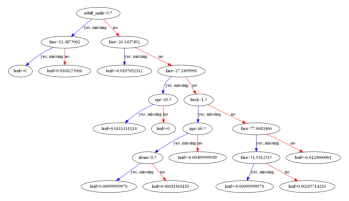

In [6]:
# 弱学習器の木構造を描画
xgboost.plot_tree(xgb, num_trees=0)

### LightGBM

In [7]:
!pip install lightgbm

In [14]:
import lightgbm as lgb
lgbmc = lgb.LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)
eval_set = [(X_test, y_test)] # 実際はvalidation用データを使用するのが正しい
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation())
lgbmc.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)

[1]	valid_0's binary_logloss: 0.56902
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.536293
[3]	valid_0's binary_logloss: 0.50876
[4]	valid_0's binary_logloss: 0.485108
[5]	valid_0's binary_logloss: 0.464864
[6]	valid_0's binary_logloss: 0.447251
[7]	valid_0's binary_logloss: 0.433086
[8]	valid_0's binary_logloss: 0.41859
[9]	valid_0's binary_logloss: 0.408127
[10]	valid_0's binary_logloss: 0.400311
[11]	valid_0's binary_logloss: 0.400311
[12]	valid_0's binary_logloss: 0.400311
[13]	valid_0's binary_logloss: 0.400311
[14]	valid_0's binary_logloss: 0.400311
[15]	valid_0's binary_logloss: 0.400311
[16]	valid_0's binary_logloss: 0.400311
[17]	valid_0's binary_logloss: 0.400311
[18]	valid_0's binary_logloss: 0.400311
[19]	valid_0's binary_logloss: 0.400311
[20]	valid_0's binary_logloss: 0.400311
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.400311


LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

In [17]:
y_pred_lgbmc = lgbmc.predict_proba(X_test)
print(f"light gbm AUC: {roc_auc_score(y_test, y_pred_lgbmc[:,1])}")

light gbm AUC: 0.9383012820512822


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

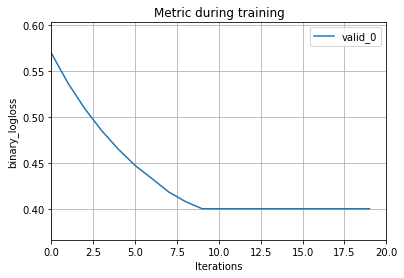

In [18]:
# 学習曲線
lgb.plot_metric(lgbmc)

<AxesSubplot:>

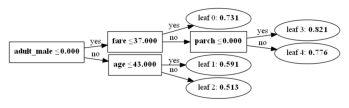

In [19]:
lgb.plot_tree(lgbmc, tree_index=0)

### CatBoost

In [21]:
!pip install catboost

In [27]:
# データ準備
df = sns.load_dataset('titanic')
df.dropna(inplace=True)
# X, yを作成
X = df.drop(['survived', 'alive'], axis=1)
y = df['survived']
# カテゴリ変数名のリスト
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
# # ラベルエンコーディング
# oe = OrdinalEncoder()
# oe.set_output(transform='pandas')
# cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
# X[cat_cols] = oe.fit_transform(X[cat_cols])
# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [29]:
from catboost import CatBoostClassifier
cbc = CatBoostClassifier(iterations=1000, learning_rate=0.01, cat_features=cat_cols)
eval_set = [(X_test, y_test)] # 実際はvalidation用データを使用するのが正しい
cbc.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=True)

0:	learn: 0.6885366	test: 0.6868442	best: 0.6868442 (0)	total: 7.2ms	remaining: 7.19s
1:	learn: 0.6814490	test: 0.6793775	best: 0.6793775 (1)	total: 43.3ms	remaining: 21.6s
2:	learn: 0.6760508	test: 0.6726860	best: 0.6726860 (2)	total: 75.6ms	remaining: 25.1s
3:	learn: 0.6712676	test: 0.6671826	best: 0.6671826 (3)	total: 104ms	remaining: 26s
4:	learn: 0.6653107	test: 0.6593995	best: 0.6593995 (4)	total: 132ms	remaining: 26.3s
5:	learn: 0.6598695	test: 0.6518437	best: 0.6518437 (5)	total: 160ms	remaining: 26.4s
6:	learn: 0.6558456	test: 0.6467404	best: 0.6467404 (6)	total: 188ms	remaining: 26.7s
7:	learn: 0.6515199	test: 0.6413944	best: 0.6413944 (7)	total: 214ms	remaining: 26.6s
8:	learn: 0.6471426	test: 0.6356173	best: 0.6356173 (8)	total: 242ms	remaining: 26.6s
9:	learn: 0.6431772	test: 0.6310513	best: 0.6310513 (9)	total: 275ms	remaining: 27.2s
10:	learn: 0.6392733	test: 0.6260433	best: 0.6260433 (10)	total: 301ms	remaining: 27.1s
11:	learn: 0.6349835	test: 0.6211657	best: 0.6211657

In [30]:
y_pred_cbc = cbc.predict_proba(X_test)
print(f"catboost AUC: {roc_auc_score(y_test, y_pred_cbc[:,1])}")

catboost AUC: 0.8942307692307693


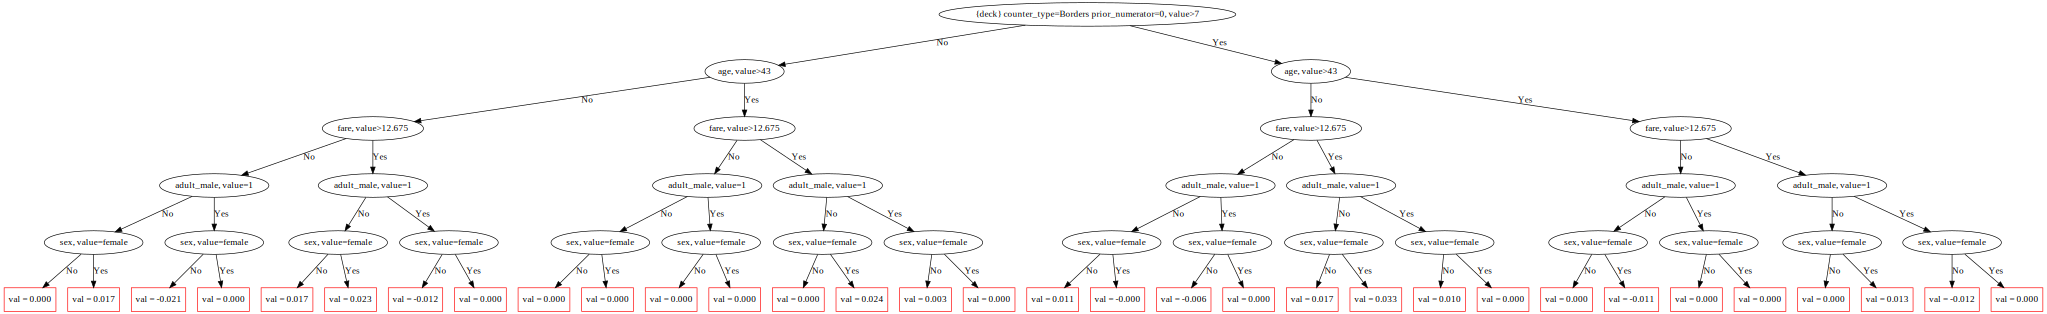

In [37]:
from catboost import Pool
pool = Pool(X_train, y_train, cat_features=cat_cols)
cbc.plot_tree(tree_idx=1, pool=pool)